In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter('ignore')

import torch
import numpy as np
from torch.utils.data import DataLoader
from pathlib import Path
from rearrangement.dataset.real_scene_dataset import RealSceneDataset
from rearrangement.evaluation.scene_prediction import ScenePrediction
from rearrangement.utils.visualization import plot_batch_predictions
from rearrangement.utils.visualization import plot_src_tgt_patches

log_dir = Path('../../data/models/')

Load data from the real evaluation dataset

In [ ]:
scene_ds = RealSceneDataset(Path('/sequoia/data2/ylabbe/datasets/pose') / 'real-cubes-1to12-600-2cam', n_objects=6, resize=(640, 480))
dataloader = DataLoader(scene_ds, collate_fn=scene_ds.collate_fn, num_workers=2, batch_size=32, shuffle=False)
rgb, mask, obs = list(dataloader)[0]
rgb = rgb[..., :3]
joints = torch.tensor(obs['joints'])
aabbs = obs['aabbs']

Load the trained model 

In [ ]:
run_id = 'state-prediction-71538'
model = ScenePrediction.from_run(log_dir, Path(run_id))

Make the full predictions (forward pass + clustering) on a batch of images

In [ ]:
objects, segm, pred = model.predict_objects(rgb, joints=joints, mask_threshold=0.9, bandwidth=0.04)

Plot the predictions:
- Left: Input image
- Middle: Object detections (extracted from instance segmentation) and gripper/robot predicted semantic segmentation
- Right: Robot 2D workspace visualization. Crosses represent predicted coordinates for each object, boxes represent the ground truth.

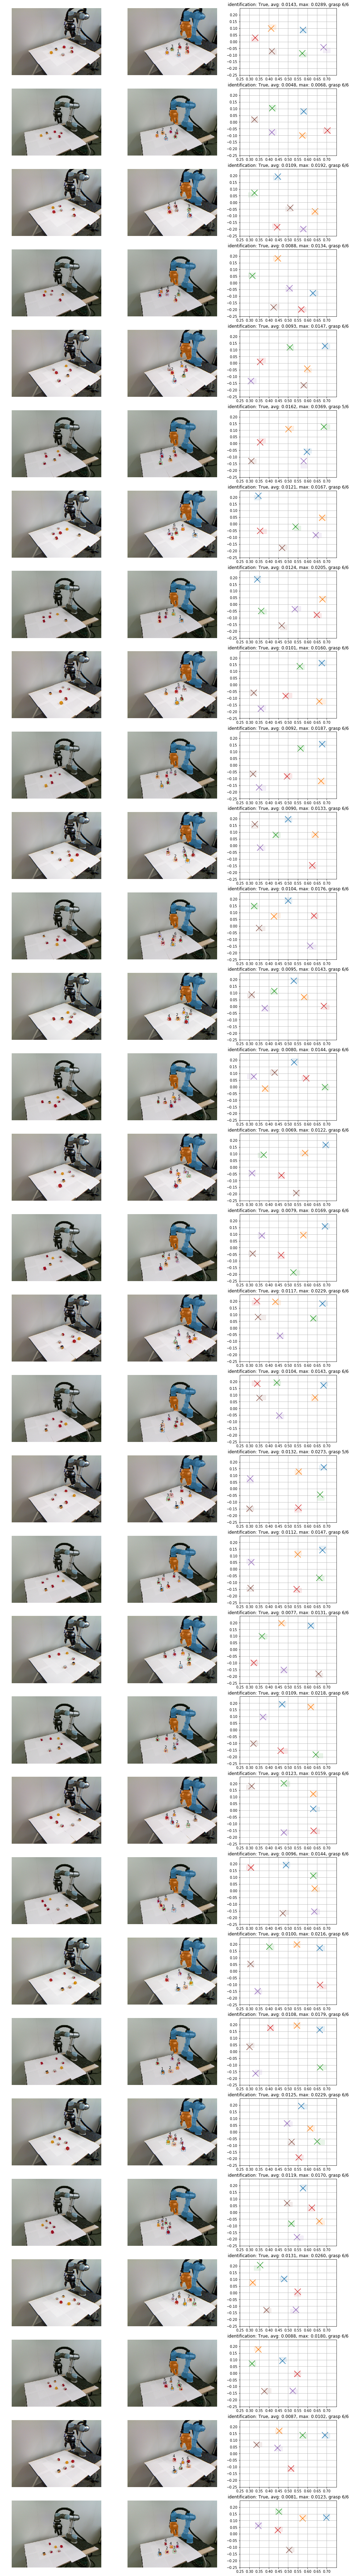

In [8]:
axs = plot_batch_predictions(rgb, aabbs, objects, segm, pred, N=32)

Match the objects between a source and a target image using AlexNet features
- Top row: Patches extracted from a (source) image.
- Bottom row: Patches extracted from a (target) image and matched against the patches of the source image.

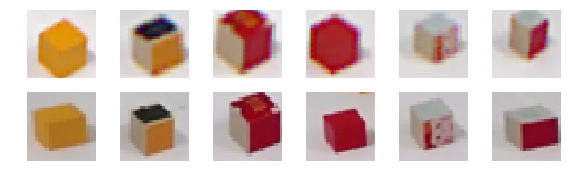

In [9]:
src_id, tgt_id = np.random.randint(len(rgb), size=2)
succ, matching, tgt_patches, src_patches, dists = model.match_src_tgt_objects(
    rgb[src_id],  segm.instance[src_id], rgb[tgt_id],  segm.instance[tgt_id])
axs = plot_src_tgt_patches(src_patches, tgt_patches, matching)